In [2]:
!pip install  --quiet langgraph
!pip install  --quiet langchain-google-genai
!pip install --quiet langchain
!pip install --quiet tavily-python langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.0/118.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.7/408.7 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.7 MB/s eta 0:00:00


In [4]:
from typing import Annotated, Literal
import textwrap
import json

from typing_extensions import TypedDict

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage
from langchain_community.tools.tavily_search import TavilySearchResults

from langgraph.graph import StateGraph, START, END
from langgraph.graph.state import CompiledStateGraph
from langgraph.graph.message import add_messages

from IPython.display import Image, display, Markdown

from google.colab import userdata
import getpass
import os

# Basics

In [5]:
# getting api key for gemini
google_api_key = userdata.get('GOOGLE_API_KEY')

#initiating a gemini model
gemini: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(model="gemini-1.5-flash",
                                                        api_key=google_api_key)

# prompt message that has role of human message (a message from human)
prompt: HumanMessage = HumanMessage(content='Hello! What is your name?', name='Gemini')

messages = [prompt]

#checking gemini response
gemini.invoke(messages).content

"I don't have a name. I am a large language model, and I am not a person. I am a computer program designed to process and generate text. 😊 \n"

We can also integrate tools with LangGraph agents and Langchain applications. Here, we will use Tavily Search

In [6]:
# tavily_api_key = userdata.get('TAVILY_API_KEY')

# # initializing a tavily search instance. We will get top 3 results in response
# tavily_search: TavilySearchResults = TavilySearchResults(max_results=3)

# # invoking the tavily search instance
# tavily_search.invoke('What is temperature in Peshawar?')

# Hello LangGraph

LangGraph is a library for building stateful, multy-actor applications with LLM's, used to create agent and multi-agent workflows

Key features include


*   Implement loops and condition on your agent workflow
*   Automatically save state after each step in the graph. Pause and resume graph execution at any point
*   Interupt graph execution to get approval of human, or allow human to edit next action planned by agent
*   Stream output



Key components include
*  **State** (input schema for all nodes and edges in the graph)
*  **Nodes** (python functions that encodes logic of agents. Recieves current State as input, perform some computation and return an updated State)
* **Edges** (python function that determine which Node to be executed based on the current State)
  * *Normal Edge* (Go directly from one node to the next)
  * *Conditional Edge* (Calls a function to determine which nodes to go to next)




Below is an example of simple LangGraph agent that reflects the basic steps required to create an agent and define a workflow for the agent

In [11]:
#Defining state
class LearningState(TypedDict):
    prompt: str

In [12]:

def node_1(state: LearningState) -> LearningState:
    print("---Node 1 State---", state)
    return {"prompt": state['prompt'] +" I am"}

def node_2(state: LearningState) -> LearningState:
    print("---Node 2 State---", state)
    return {"prompt": state['prompt'] +" happy!"}

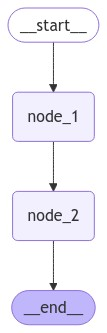

In [13]:
#initializing graph instance
builder: StateGraph = StateGraph(state_schema=LearningState)

#adding nodes to the graph
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)

#adding edges to the graph
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", END)

#compulting the graph
graph: CompiledStateGraph = builder.compile()

#displaying the agent graph
display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
graph.invoke({"prompt" : "Hi"})

---Node 1 State--- {'prompt': 'Hi'}
---Node 2 State--- {'prompt': 'Hi I am'}


{'prompt': 'Hi I am happy!'}

The above code showcase how the state flows through the agent and how it changes. Now, we will integrate LLM with the agent and see how it fares

In [26]:
google_api_key = userdata.get('GOOGLE_API_KEY')

llm: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(model="gemini-1.5-flash",
                                                    api_key=google_api_key)

class State(TypedDict):
    prompt: str
    response: str

# creating node
def node_1(state: State):
    print("---Node 1 State---", state)
    prompt = state["prompt"]
    print(f"Prompt: {prompt}")

    ai_msg: AIMessage = llm.invoke(prompt)
    return {"prompt": prompt, "response": ai_msg.content}

# building graph
builder: StateGraph = StateGraph(state_schema=State)

# defining nodes of the graph
builder.add_node("node_1", node_1)

# adding edges to the graph
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# compiling graph
graph: CompiledStateGraph = builder.compile()


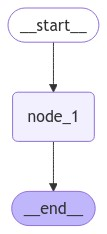

In [27]:
# Viewing graph
display(Image(graph.get_graph().draw_mermaid_png()))

In [28]:
result = graph.invoke({"prompt" : "Motivate me to learn LangGraph"})

---Node 1 State--- {'prompt': 'Motivate me to learn LangGraph'}
Prompt: Motivate me to learn LangGraph


In [33]:
def to_markdown(text)-> Markdown:
    text : str = text.replace("•", "  *")
    return Markdown(textwrap.indent(text, "> ", predicate=lambda _: True))

to_markdown(result['response'])

> ## Why Learn LangGraph? 🚀
> 
> LangGraph is a powerful tool that can revolutionize how you work with language data. Here's why you should consider diving in:
> 
> **1. Unlocking the Power of Knowledge Graphs:**
> 
> * **Semantic Understanding:** LangGraph goes beyond simple text analysis, building knowledge graphs that capture the relationships and meanings within your data. This allows for deeper insights and more accurate understanding.
> * **Data Exploration:**  LangGraph provides a visual representation of your knowledge graph, making it easy to navigate, explore connections, and discover hidden patterns.
> * **Enhanced Search and Retrieval:**  Find information faster and more precisely with semantic search capabilities powered by the knowledge graph. 
> 
> **2. Empowering Your Applications:**
> 
> * **Intelligent Chatbots:** Build more sophisticated chatbots that can understand context, provide accurate answers, and engage in natural conversations.
> * **Personalized Recommendations:**  Deliver tailored recommendations based on user preferences and interactions, thanks to the detailed knowledge graph.
> * **Enhanced Content Creation:**  Generate high-quality content, analyze sentiment, and identify key themes using LangGraph's powerful features.
> 
> **3. A Future-Proof Skill:**
> 
> * **Growing Demand:**  The field of knowledge graphs is rapidly expanding, creating increasing demand for skilled professionals.
> * **Versatility:**  LangGraph is applicable across various domains, from healthcare and finance to marketing and research.
> * **Innovation:**  Be at the forefront of innovation by leveraging the power of knowledge graphs for cutting-edge applications.
> 
> **4. Easy to Learn and Use:**
> 
> * **User-Friendly Interface:**  LangGraph offers an intuitive interface that simplifies the process of building and managing knowledge graphs.
> * **Extensive Documentation:**  Comprehensive documentation and tutorials make it easy to get started and learn the ropes.
> * **Active Community:**  Join a supportive community of LangGraph users and developers for help and inspiration.
> 
> **5. Unlock Your Potential:**
> 
> * **Expand Your Skillset:**  Learning LangGraph will enhance your data analysis and language processing skills, making you a more valuable asset in any organization.
> * **Gain a Competitive Edge:**  Differentiate yourself from the competition by mastering this powerful and in-demand technology.
> * **Fuel Your Creativity:**  Unlock new possibilities and drive innovation by leveraging the unique capabilities of LangGraph.
> 
> **Don't just process language, understand it. Learn LangGraph and unlock the full potential of your data!** 


Let's try something else

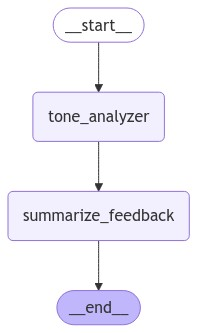

---Node 1 State--- {'text': 'The support team was very helpful, but I faced a delay in receiving my product. It arrived with minor damage.'}
Respose of tone analyzer node: The tone of the feedback is **mixed**. 

Here's a breakdown:

* **Positive:** "The support team was very helpful" indicates a positive experience with customer service.
* **Negative:** "I faced a delay in receiving my product" and "It arrived with minor damage" both express dissatisfaction with the product delivery and condition. 

**Overall:** While the customer acknowledges the helpfulness of the support team, the negative aspects of the delayed and damaged product outweigh the positive, making the overall sentiment leaning towards negative. 

---Node 2 State--- {'text': 'The support team was very helpful, but I faced a delay in receiving my product. It arrived with minor damage.', 'response': 'The tone of the feedback is **mixed**. \n\nHere\'s a breakdown:\n\n* **Positive:** "The support team was very helpful" ind

> The customer received helpful support but experienced a delayed delivery and minor damage to their product. 


In [54]:
class State(TypedDict):
    text: str
    response: str

def tone_analyzer(state: State):
    print("---Node 1 State---", state)
    prompt = state["text"]
    system_message = f"Analyze the tone of this customer feedback: '{prompt}' and respond with whether it’s positive, neutral, or negative."

    ai_msg: AIMessage = llm.invoke(system_message)
    print(f"Respose of tone analyzer node: {ai_msg.content}")

    return {"text": prompt, "response": ai_msg.content}

def summarize_feedback(state):
    print("---Node 2 State---", state)
    prompt = state["text"]
    print(f"Prompt: {prompt}")
    system_message = f"Provide a concise summary of the main points in this customer feedback: '{prompt}'"

    ai_msg: AIMessage = llm.invoke(system_message)
    print(f"Respose of summarizer node: {ai_msg.content}")

    return {"text": prompt, "response": ai_msg.content}

# Building graph for the customer feedback analysis

builder: StateGraph = StateGraph(state_schema=State)

builder.add_node("tone_analyzer", tone_analyzer)
builder.add_node("summarize_feedback", summarize_feedback)

# Define the flow
builder.add_edge(START, "tone_analyzer")
builder.add_edge("tone_analyzer", "summarize_feedback")
builder.add_edge("summarize_feedback", END)

# Compile and visualize the graph
graph: CompiledStateGraph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

# Test the graph with an example feedback
result = graph.invoke({"text": "The support team was very helpful, but I faced a delay in receiving my product. It arrived with minor damage."})

to_markdown(result['response'])


Lets try another usecase

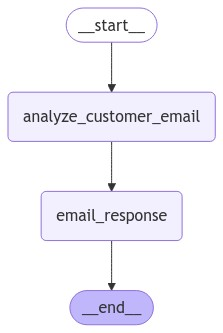

---Node 1 State--- {'email': 'Dear Customer Support Team,\n\nI hope this message finds you well. I am reaching out regarding my recent order, #[Order12345], placed on October 20th. I was initially informed that it would arrive within 5-7 business days, but it has now been over two weeks with no updates on the delivery status.\n\nAdditionally, when I attempted to track the package, I found that the tracking link provided was invalid. I understand there may be delays, but I would appreciate it if you could provide an update on the expected arrival date.\n\nIf possible, please advise if there’s anything further I need to do on my end. I would also appreciate information on any potential compensation or discounts for the delay.\n\nThank you very much for your assistance, and I look forward to hearing back soon.\n\nBest regards,\nEmily Thompson'}
Respose of email analyzer node: The tone of the email is **polite but firm**. Emily starts by expressing hope that the customer support team is we

> Subject: Re: Order #[Order12345] - Delivery Update
> 
> Dear Emily,
> 
> Thank you for reaching out regarding your order #[Order12345]. We apologize for the delay in your delivery and any inconvenience this may have caused.
> 
> We understand your frustration with the invalid tracking link. We are currently experiencing some technical difficulties with our tracking system, and we are working to resolve this as quickly as possible.  
> 
> We are investigating the status of your order and will provide you with a confirmed delivery date as soon as possible. We will also ensure the tracking link is updated and functional.
> 
> We appreciate your patience and understanding. In the meantime, please do not hesitate to contact us if you have any further questions or concerns.
> 
> Sincerely,
> 
> The [Company Name] Customer Support Team 


In [55]:
class State(TypedDict):
    email: str
    response: str

def analyze_customer_email(state: State):
    print("---Node 1 State---", state)
    email = state["email"]

    system_message = f"Analyze the tone and the urgence of the user email {email}"
    ai_msg: AIMessage = llm.invoke(system_message)
    print(f"Respose of email analyzer node: {ai_msg.content}")
    return {"email": email, "response": ai_msg.content}

def email_response(state: State):
  print("---Node 2 State ---", state)
  analysis = state['email']

  system_message = f"Based on the tone and urgence of the user email {analysis}, write a response email"
  ai_msg: AIMessage = llm.invoke(system_message)
  print(f"Respose of email response node: {ai_msg.content}")

  return {"email": analysis, "response": ai_msg.content}

builder: StateGraph = StateGraph(state_schema=State)

builder.add_node("analyze_customer_email", analyze_customer_email)
builder.add_node("email_response", email_response)

builder.add_edge(START, "analyze_customer_email")
builder.add_edge('analyze_customer_email', 'email_response')
builder.add_edge('email_response', END)

graph: CompiledStateGraph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

user_email = """Dear Customer Support Team,

I hope this message finds you well. I am reaching out regarding my recent order, #[Order12345], placed on October 20th. I was initially informed that it would arrive within 5-7 business days, but it has now been over two weeks with no updates on the delivery status.

Additionally, when I attempted to track the package, I found that the tracking link provided was invalid. I understand there may be delays, but I would appreciate it if you could provide an update on the expected arrival date.

If possible, please advise if there’s anything further I need to do on my end. I would also appreciate information on any potential compensation or discounts for the delay.

Thank you very much for your assistance, and I look forward to hearing back soon.

Best regards,
Emily Thompson"""

result = graph.invoke({"email": user_email})

to_markdown(result['response'])
